# Event Sampling

## Prerequisites 

To understand how to generate a Model, a Dataset and how to fit the data, please refer to the `~gammapy.modeling.models.SkyModel` and [`simulate_3d`](https://docs.gammapy.org/dev/notebooks/simulate_3d).

## Context 

This tutorial describes how to sampling events for an observation of a given Sky model and IRF. The main aim of the tutorial is to explain how to set the minimal configuration for the event sampling and how to obtain an output photon event list.

The core of the simulation lies into the Gammapy `~gammapy.datasets.MapDatasetEventSampler` class, which is based on the inverse cumulative distribution function [(Inverse CDF)](https://en.wikipedia.org/wiki/Cumulative_distribution_function#Inverse_distribution_function_(quantile_function)). 

The `MapDatasetEventSampler` takes in input a `~gammapy.datasets.Dataset` object containing the Sky model. The class evaluates the map of predicted counts per bin and then samples it, giving in output a set of events with true coordinates, true energies and times of arrival. It is also possible to then apply IRF corrections (i.e. PSF and energy dispersion) in order to obtain reconstructed coordinates and energies of the sampled events. 

The metadata in the event-list are then catched from an `gammapy.data.Observations` object. 

## Objective
To sample events from a given Sky model, obtaining an event-list with coordinates, energies and times for each event.

## Proposed approach

In this section we show how to define an `Observation` and to create the `Dataset` object needed for the event sampling (for more info about to create `Dataset` objects, please visit this [link](https://docs.gammapy.org/dev/notebooks/analysis_2.html#Preparing-reduced-datasets-geometry)). We define the Sky model and then we sample events from that. We show how to do it for a point-like source and a template map. We finally check consistency by fitting the sampled events with the same Sky model.

## Setup
As usual, we'll start with some general imports...


In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import copy
import astropy.units as u
from astropy.coordinates import SkyCoord
from gammapy.data import DataStore, GTI, Observation
from gammapy.datasets import MapDataset, MapDatasetEventSampler
from gammapy.maps import MapAxis, WcsGeom, Map
from gammapy.irf import load_cta_irfs
from gammapy.makers import MapDatasetMaker
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    Model, Models, SkyModel, 
    PowerLawSpectralModel, 
    PointSpatialModel,
    GaussianSpatialModel,
    SkyDiffuseCube
)
from regions import CircleSkyRegion

### Define an Observation

We firstly create an `Observation` object that containts the pointing position, the GTIs and the reference IRFs. Hereafter, we select the IRF from the South configuration of the CTA DC1. We set the pointing position of the simulated field at the Galactic Center and we fix the exposure time to 8 hr.

Let's start with some initial settings:

In [3]:
IRF_FILE = "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"

POINTING = SkyCoord(0.0, 0.0, frame="galactic", unit="deg")
LIVETIME = 1 * u.hr

Now we can create the observation:

In [4]:
irfs = load_cta_irfs(IRF_FILE)
observation = Observation.create(
    obs_id=1001, pointing=POINTING, livetime=LIVETIME, irfs=irfs
)

### Define the MapDataset

We now can generate the `Dataset` object. We define the energy axes (true and reconstruncted), the migration axis and the geometry of the observation. 

*This is a crucial point for the correct configuration of the event sampler. Indeed the spatial and energetic binning should be treaten carefully and the finer the better. For this reason, we suggest to define the energy axes by setting a minimum binning of least 10-20 bins per decade for all the source of interest. The spatial binning may instead be different from source to source and, at first order, it should be adopted a binning significantly smaller than expected source size.*

For the examples that will be shown hereafter, we set the geometry of the dataset to a field of view of 2degx2deg and we  bin the spatial map with pixels of 0.02 deg.

In [5]:
ENERGY_AXIS = MapAxis.from_energy_bounds("0.1 TeV", "100 TeV", nbin=10, per_decade=True)
ENERGY_AXIS_TRUE = MapAxis.from_energy_bounds("0.03 TeV", "300 TeV", nbin=20, per_decade=True, name="energy_true")
MIGRA_AXIS = MapAxis.from_bounds(0.5, 2, nbin=150, node_type="edges", name="migra")

WCS_GEOM = WcsGeom.create(
    skydir=POINTING, width=(2, 2), binsz=0.02, frame="galactic", axes=[ENERGY_AXIS]
)

In the following, the dataset is creating by selecting the effective area, background model, the PSF and the Edisp from the IRF. The `Dataset` thus created can be saved into a FITS file just using the `write()` function. We put it into the `evt_sampling` sub-folder:

In [6]:
%%time
empty = MapDataset.create(WCS_GEOM, energy_axis_true=ENERGY_AXIS_TRUE, migra_axis=MIGRA_AXIS)
maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])
dataset = maker.run(empty, observation)

dataset.write('./evt_sampling/dataset.fits', overwrite=True)

CPU times: user 1.63 s, sys: 564 ms, total: 2.19 s
Wall time: 2.29 s


### Define the Sky model: point-like source

First of all, let's define a [`Sky model`](https://docs.gammapy.org/dev/notebooks/models.html) for a point-like source centered 0.5 deg far from the Galactic Center and with a power-law spectral shape. We then save the model into a yaml file.

In [7]:
spectral_model_pwl = PowerLawSpectralModel(index=2,amplitude="1e-12 TeV-1 cm-2 s-1", reference='1 TeV')
spatial_model_point = PointSpatialModel(lon_0= "0 deg", lat_0="0.5 deg", frame='galactic')
sky_model_pntpwl = SkyModel(spectral_model=spectral_model_pwl, spatial_model=spatial_model_point)

models_pntpwl = Models([sky_model_pntpwl])

file_model = "./evt_sampling/point-pwl.yaml"
models_pntpwl.write(file_model, overwrite=True)

### Sampling the source and background events

Now, we can finally add the `Skymodel` we want to simulate to the `Dataset` container:

In [8]:
dataset.models.extend(models_pntpwl)
print(dataset.models)

Models

Component 0: BackgroundModel

  Name                      : 1U3sSV-K-bkg
  Datasets names            : ['1U3sSV-K']
  Parameters:
    norm                    :   1.000              
    tilt         (frozen)   :   0.000              
    reference    (frozen)   :   1.000  TeV         

Component 1: SkyModel

  Name                      : MTzInqY-
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : None
  Parameters:
    lon_0                   :   0.000  deg         
    lat_0                   :   0.500  deg         
    index                   :   2.000              
    amplitude               :   1.00e-12  1 / (cm2 s TeV)
    reference    (frozen)   :   1.000  TeV         




The next step shows how to sample the events with the `MapdatasetEventSampler` class. The class requests a random number seed generator that we set with `random_state=0`, the `Dataset` and the `Observation` object. From the latter, the `MapDatasetEventSampler` class takes all the meta data information.

In [9]:
%%time
sampler = MapDatasetEventSampler(random_state=0)
events = sampler.run(dataset, observation)

CPU times: user 1.25 s, sys: 136 ms, total: 1.39 s
Wall time: 1.42 s


The output of the event-sampler is an event list with coordinates, energies and time of arrivals of the source and background events. Source and background events are flagged by the MC_ID identifier (where 0 is the default identifier for the background).

In [10]:
events.table

ENERGY,RA,DEC,TIME,MC_ID,ENERGY_TRUE,RA_TRUE,DEC_TRUE,EVENT_ID
TeV,deg,deg,s,,TeV,deg,deg,
float64,float64,float64,float64,int64,float64,float64,float64,int64
0.28502120882709486,266.1220854199147,-28.484722277816232,1781.469291402027,0,--,--,--,0
0.10092406368757127,267.21268472903887,-29.067192642884102,701.8231961410493,0,--,--,--,1
0.29859171011912405,266.609440744491,-30.009498643966975,3331.634774291888,0,--,--,--,2
0.11302468262102787,267.4655692311438,-29.103415029825953,2419.8781312443316,0,--,--,--,3
0.11099090258465992,267.43783560274954,-29.12441513148956,1426.3578500133008,0,--,--,--,4
0.12284830644527701,267.0295343954879,-28.751165186344092,3245.097808423452,0,--,--,--,5
0.47691920974773516,265.8475322888417,-29.758458562746878,3318.2898953324184,0,--,--,--,6
0.30701885337767354,266.4606867453822,-29.894916057082206,2252.01646189671,0,--,--,--,7


In [11]:
print(f"Source events: {len(np.where(events.table['MC_ID']==2)[0])}")
print(f"Background events: {len(np.where(events.table['MC_ID']==0)[0])}")

Source events: 214
Background events: 11804


We can inspect the properties of the simulated events as follows:

/anaconda2/envs/gammapy-dev/lib/python3.7/site-packages/gammapy-0.17.dev387+gb59b176.d20200311-py3.7-macosx-10.7-x86_64.egg/gammapy/data/event_list.py:613: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


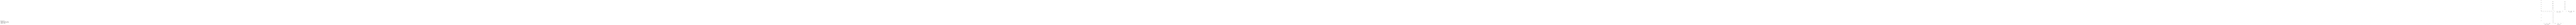

In [12]:
events.peek()

Let's write the photon event list to a FITS file:

In [13]:
events.table.write("./evt_sampling/events_0001.fits", overwrite=True)

You can now load the event list with `Datastore.from_events_files()` and make your own analysis following the instructions in [`analysis_2`](https://docs.gammapy.org/dev/notebooks/analysis_2.html).

#### Generate a skymap
A skymap of the simulated events is the following:

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x129094198>)

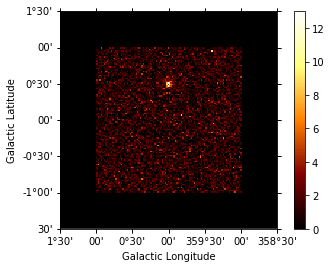

In [14]:
counts = Map.create(frame="galactic", skydir=(0, 0.), binsz=0.02, npix=(100, 100))
counts.fill_events(events)
counts.plot(add_cbar=True)

#### Fit the simulated data
We can now check the sake of the event sampling by fitting the data (a tutorial of source fitting is [here](https://docs.gammapy.org/dev/notebooks/analysis_2.html#Fit-the-model) and [here](https://docs.gammapy.org/dev/notebooks/simulate_3d)). We make use of the same `Skymodel` adopted for the simulation. 
Hence, we firstly read the `Dataset` and the model file, and we fill the `Dataset` with the sampled events.

In [15]:
dataset = MapDataset.read("./evt_sampling/dataset.fits")
models_sim_point = Models.read("./evt_sampling/point-pwl.yaml")

counts = Map.from_geom(WCS_GEOM)
counts.fill_events(events)
dataset.counts = counts
dataset.models.extend(models_sim_point)

Let's fit the data and look at the results:

In [16]:
%%time
fit = Fit([dataset])
result = fit.run(optimize_opts={"print_level": 1})
print(result)

------------------------------------------------------------------
| FCN = 2.753E+05               |     Ncalls=102 (102 total)     |
| EDM = 7.95E-05 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 102
	total stat : 275315.75

CPU times: user 16.9 s, 

In [17]:
result.parameters.to_table()

name,value,error,unit,min,max,frozen
str9,float64,float64,str14,float64,float64,bool
norm,9.948e-01,4.675e-03,,0.000e+00,nan,False
tilt,0.000e+00,0.000e+00,,nan,nan,True
reference,1.000e+00,0.000e+00,TeV,nan,nan,True
lon_0,2.368e-03,3.493e-03,deg,nan,nan,False
lat_0,5.026e-01,3.385e-03,deg,-9.000e+01,9.000e+01,False
index,1.957e+00,6.259e-02,,nan,nan,False
amplitude,9.987e-13,9.755e-14,cm-2 s-1 TeV-1,nan,nan,False
reference,1.000e+00,0.000e+00,TeV,nan,nan,True


The results looks great!

## Extended source using a template
The event sampler can also work with a template `Skymodel`.
Here we use the interstellar emission model map of the Fermi 3FHL, which can found in the GAMMAPY data repository.

We proceed following the same steps showed and we finally have a look at the events properties:

In [18]:
diffuse = SkyDiffuseCube.read(
    "$GAMMAPY_DATA/fermi-3fhl-gc/gll_iem_v06_gc.fits.gz"
)
models_diffuse = Models([diffuse])

file_model = "./evt_sampling/diffuse.yaml"
models_diffuse.write(file_model, overwrite=True)

In [19]:
dataset = MapDataset.read("./evt_sampling/dataset.fits")
dataset.models.extend(models_diffuse)
print(dataset.models)

Models

Component 0: BackgroundModel

  Name                      : -pwCxnC3
  Datasets names            : ['qx9mClNZ']
  Parameters:
    norm                    :   1.000              
    tilt         (frozen)   :   0.000              
    reference    (frozen)   :   1.000  TeV         

Component 1: SkyDiffuseCube

  Name                      : gll_iem_v06_gc.fits
  Datasets names            : None
  Parameters:
    norm                    :   1.000              
    tilt         (frozen)   :   0.000              
    reference    (frozen)   :   1.000  TeV         




In [20]:
%%time
sampler = MapDatasetEventSampler(random_state=0)
events = sampler.run(dataset, observation)

AttributeError: 'SkyDiffuseCube' object has no attribute 'temporal_model'

/anaconda2/envs/gammapy-dev/lib/python3.7/site-packages/gammapy-0.17.dev387+gb59b176.d20200311-py3.7-macosx-10.7-x86_64.egg/gammapy/data/event_list.py:613: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


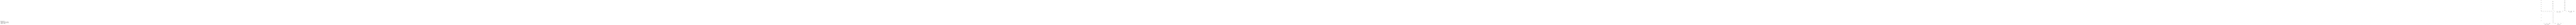

In [21]:
events.peek()

## Exercises
- Try to sample events for an extended source (e.g. a radial gaussian morphology);
- Change the spatial model and the spectrum of the simulated Sky model;
- Include a temporal model in the simulation